### Curriculum classifier demo

This notebook documents an exploration of machine learning classifiers with a focus on **predictive accuracy** and **fairness metrics**. The main goals of this analysis are:
- To evaluate the performance of different classifiers using various metrics.
- To examine the trade-offs between accuracy and fairness across models.

#### Dataset
The dataset is the fairlearn adult dataset.

Sensitive Features: **Race** and **Sex**.
Target: **Salary** (<=50K, >50K)

#### Metrics Evaluated
The notebook assesses models using:
- **Accuracy, Recall, and F1 Score** for predictive performance.
- **Fairness Metrics**:
  - **Demographic Parity Difference** and **Ratio**.
  - **Equalized Odds Difference**.
  - **Equal Opportunity Difference**.

#### Models Tested
The following classifiers are analyzed:
1. **Curriculum Classifier (Entropy-Based)**: Emphasizes predictive power but has moderate fairness concerns.
2. **Curriculum Classifier (Average Confidence-Based)**: Prioritizes fairness at the cost of some predictive performance.
3. **Stochastic Gradient Descent (SGD) Classifier**: Provides a balance but performs poorly on fairness and accuracy.

The notebook concludes with recommendations for model selection based on use-case priorities.


In [213]:
from fairlearn.datasets import fetch_adult

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

from src.classifiers.curriculum_classifier import CurriculumClassifier

### Import dataset

The following code processes the **Adult Income dataset** from `sklearn.datasets` to prepare it for fairness evaluation:

In [214]:
X, y = fetch_adult(return_X_y=True, as_frame=True)
sensitive_feature_names = ['sex', 'race']

sensitive_features = X[sensitive_feature_names]
X = X.drop(columns=sensitive_feature_names)

X.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64

### Replace missing values using the mode

In [215]:
X['workclass'].fillna(X.mode()['workclass'][0], inplace=True)
X['occupation'].fillna(X.mode()['occupation'][0], inplace=True)
X['native-country'].fillna(X.mode()['native-country'][0], inplace=True)

C:\Users\Tine Šuster\AppData\Local\Temp\ipykernel_16080\3529112877.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['workclass'].fillna(X.mode()['workclass'][0], inplace=True)
C:\Users\Tine Šuster\AppData\Local\Temp\ipykernel_16080\3529112877.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

### Encode categorical features

In [216]:
# Encode categorical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X = preprocessor.fit_transform(X).toarray()

### Split the dataset into training and test sets

- Random seed is set to 1234 for reproducibility
- The dataset is split into training and test sets using an 80-20 split ratio
- Features, target, and sensitive features are split accordingly
- The `CurriculumClassifier` is instantiated with an SGDClassifier once for each method
- The SGDClassifier is instantiated separately

Target is salary, with the following classes:
- <=50K
- \>50K

In [217]:
random_seed = 1234

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X, y, sensitive_features, test_size=0.2, random_state=random_seed
)

curriculum_classifier_ent = CurriculumClassifier(base_estimator=SGDClassifier(random_state=random_seed),
                                                 method='entropy', n_groups=3)
curriculum_classifier_ent.fit(X_train, y_train)

curriculum_classifier_acc = CurriculumClassifier(base_estimator=SGDClassifier(random_state=random_seed),
                                                 method='avg_confidence', n_groups=3)
curriculum_classifier_acc.fit(X_train, y_train)

sgd_classifier = SGDClassifier(random_state=random_seed)
sgd_classifier.fit(X_train, y_train)

SGDClassifier(random_state=1234)

### Make predictions for each classifier

In [218]:
y_pred_curriculum_ent = curriculum_classifier_ent.predict(X_test)
y_pred_curriculum_acc = curriculum_classifier_acc.predict(X_test)
y_pred_sgd = sgd_classifier.predict(X_test)

### Calculate standard metrics for each classifier

In [219]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

y_pred_curriculum_accuracy_ent = accuracy_score(y_test, y_pred_curriculum_ent)
y_pred_curriculum_recall_ent = recall_score(y_test, y_pred_curriculum_ent, average='weighted')
y_pred_curriculum_f1_ent = f1_score(y_test, y_pred_curriculum_ent, average='weighted')

y_pred_curriculum_accuracy_acc = accuracy_score(y_test, y_pred_curriculum_acc)
y_pred_curriculum_recall_acc = recall_score(y_test, y_pred_curriculum_acc, average='weighted')
y_pred_curriculum_f1_acc = f1_score(y_test, y_pred_curriculum_acc, average='weighted')

y_pred_sgd_accuracy = accuracy_score(y_test, y_pred_sgd)
y_pred_sgd_recall = recall_score(y_test, y_pred_sgd, average='weighted')
y_pred_sgd_f1 = f1_score(y_test, y_pred_sgd, average='weighted')

### Plot metrics for each classifier

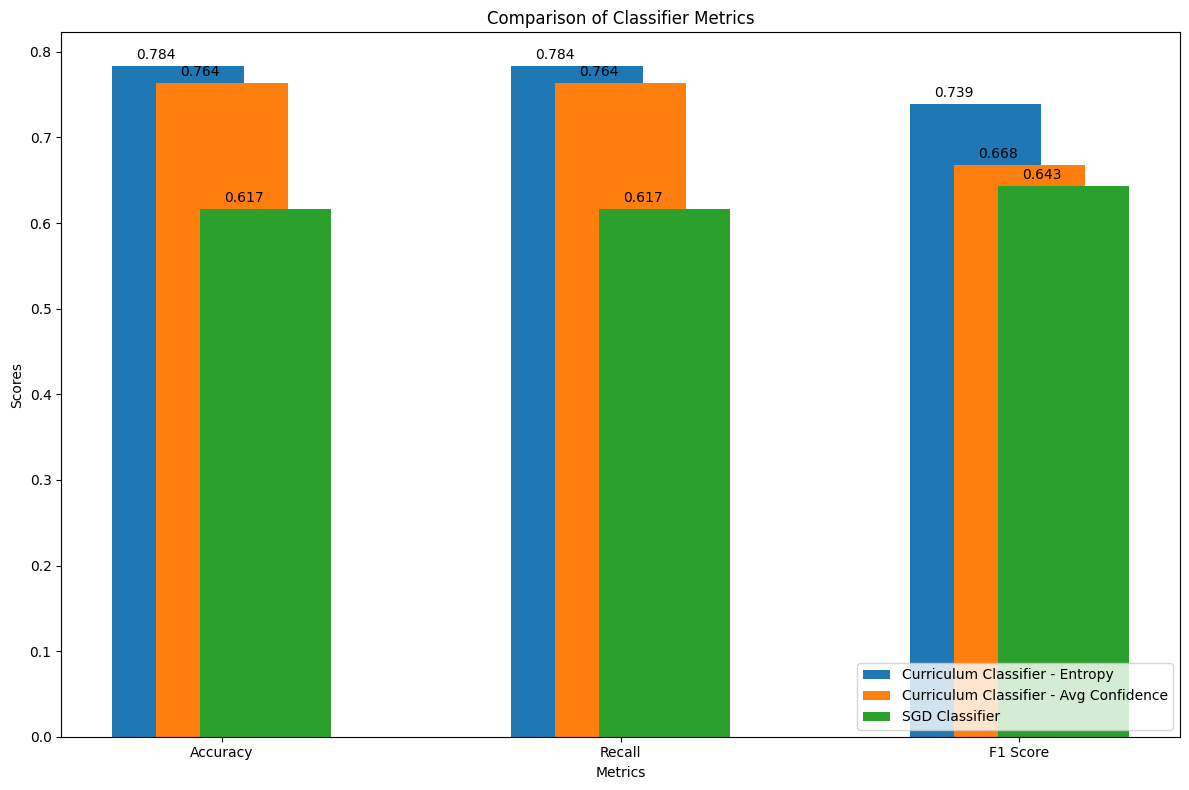

In [220]:
import matplotlib.pyplot as plt
import numpy as np

curriculum_ent_metrics = [
    y_pred_curriculum_accuracy_ent,
    y_pred_curriculum_recall_ent,
    y_pred_curriculum_f1_ent
]

curriculum_acc_metrics = [
    y_pred_curriculum_accuracy_acc,
    y_pred_curriculum_recall_acc,
    y_pred_curriculum_f1_acc
]

sgd_metrics = [
    y_pred_sgd_accuracy,
    y_pred_sgd_recall,
    y_pred_sgd_f1
]

metric_names = ['Accuracy', 'Recall', 'F1 Score']

x = np.arange(len(metric_names))

width = 0.33
fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width / 3, curriculum_ent_metrics, width, label='Curriculum Classifier - Entropy')
bars2 = ax.bar(x, curriculum_acc_metrics, width, label='Curriculum Classifier - Avg Confidence')
bars3 = ax.bar(x + width / 3, sgd_metrics, width, label='SGD Classifier')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Classifier Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend(loc='lower right')


def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(bar.get_x() + bar.get_width() / 3, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

fig.tight_layout()

plt.show()

### Calculate fairness metrics
Also encode class labels for fairness metrics calculation:

- Demographic Parity Difference (DPD)
- Equalized Odds Difference (EOD)
- Equal Opportunity Difference (EQOD)
- Demographic Parity Ratio (DPR)
- Equal Opportunity Ratio (EOR)

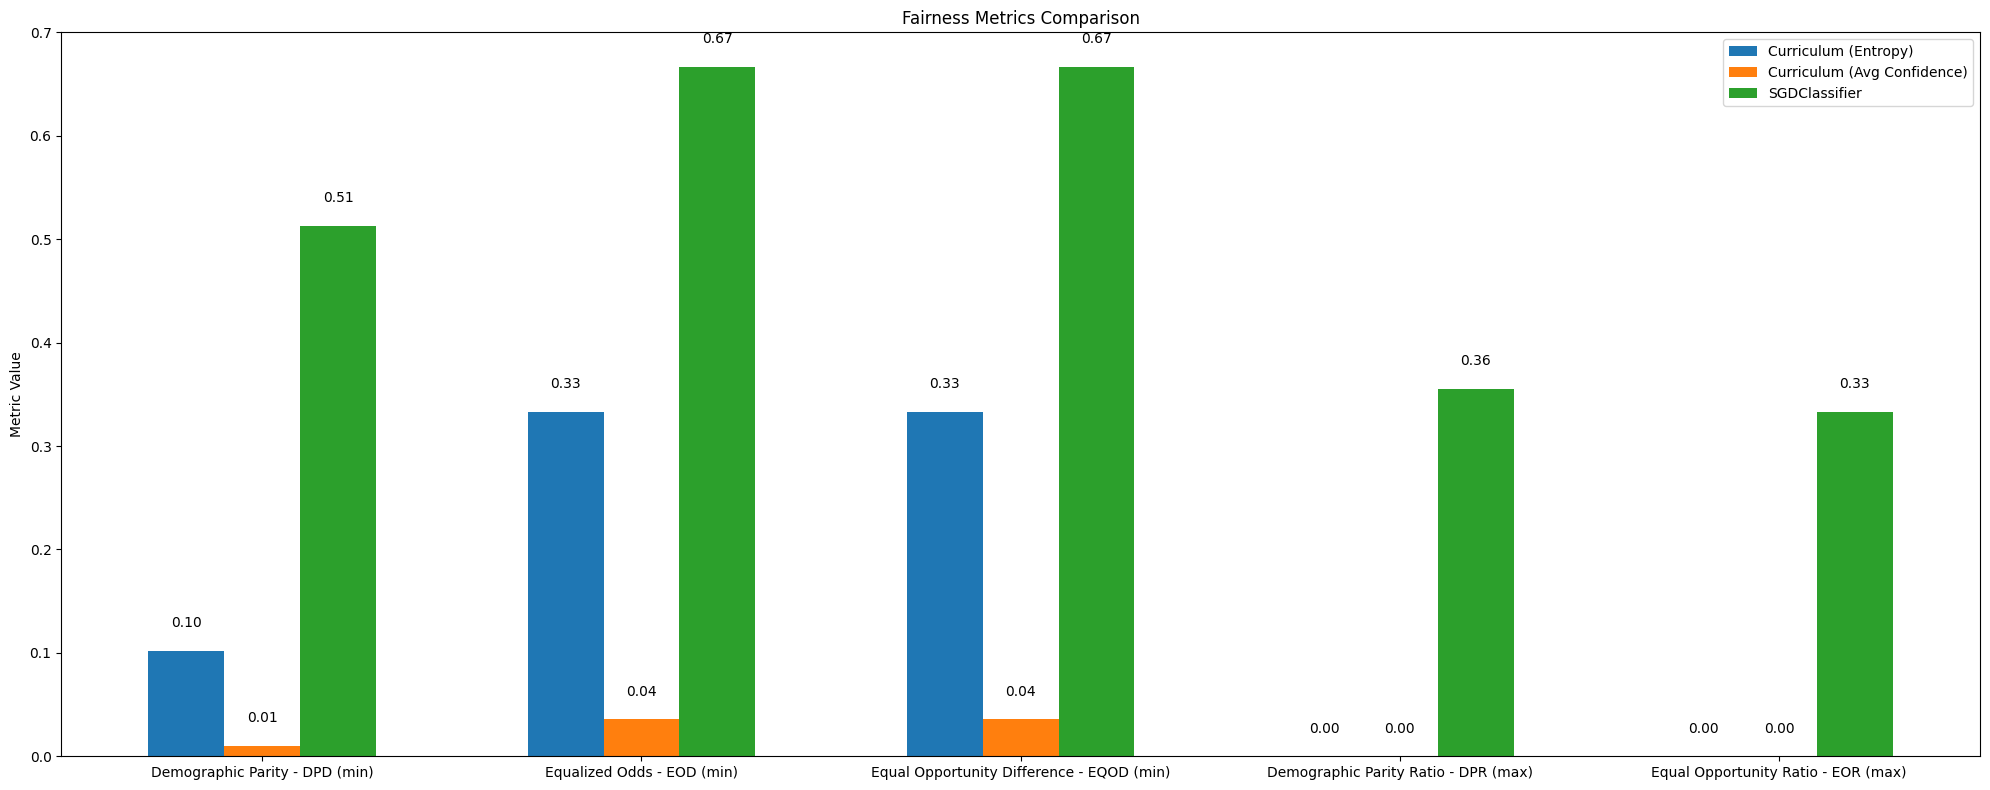

In [221]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference, equal_opportunity_difference, \
    demographic_parity_ratio, equal_opportunity_ratio
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_curriculum_ent_encoded = label_encoder.transform(y_pred_curriculum_ent)
y_pred_curriculum_acc_encoded = label_encoder.transform(y_pred_curriculum_acc)
y_pred_sgd_encoded = label_encoder.transform(y_pred_sgd)

# Entropy
dpd_ent = demographic_parity_difference(y_test_encoded, y_pred_curriculum_ent_encoded,
                                        sensitive_features=sensitive_test)
eod_ent = equalized_odds_difference(y_test_encoded, y_pred_curriculum_ent_encoded, sensitive_features=sensitive_test)
eqod_ent = equal_opportunity_difference(y_test_encoded, y_pred_curriculum_ent_encoded,
                                        sensitive_features=sensitive_test)
dpr_ent = demographic_parity_ratio(y_test_encoded, y_pred_curriculum_ent_encoded, sensitive_features=sensitive_test)
eor_ent = equal_opportunity_ratio(y_test_encoded, y_pred_curriculum_ent_encoded, sensitive_features=sensitive_test)

# Avg Confidence
dpd_acc = demographic_parity_difference(y_test_encoded, y_pred_curriculum_acc_encoded,
                                        sensitive_features=sensitive_test)
eod_acc = equalized_odds_difference(y_test_encoded, y_pred_curriculum_acc_encoded, sensitive_features=sensitive_test)
eqod_acc = equal_opportunity_difference(y_test_encoded, y_pred_curriculum_acc_encoded,
                                        sensitive_features=sensitive_test)
dpr_acc = demographic_parity_ratio(y_test_encoded, y_pred_curriculum_acc_encoded, sensitive_features=sensitive_test)
eor_acc = equal_opportunity_ratio(y_test_encoded, y_pred_curriculum_acc_encoded, sensitive_features=sensitive_test)

# SGD
dpd_sgd = demographic_parity_difference(y_test_encoded, y_pred_sgd_encoded, sensitive_features=sensitive_test)
eod_sgd = equalized_odds_difference(y_test_encoded, y_pred_sgd_encoded, sensitive_features=sensitive_test)
eqod_sgd = equal_opportunity_difference(y_test_encoded, y_pred_sgd_encoded, sensitive_features=sensitive_test)
dpr_sgd = demographic_parity_ratio(y_test_encoded, y_pred_sgd_encoded, sensitive_features=sensitive_test)
eor_sgd = equal_opportunity_ratio(y_test_encoded, y_pred_sgd_encoded, sensitive_features=sensitive_test)

values_ent = [dpd_ent, eod_ent, eqod_ent, dpr_ent, eor_ent]
values_acc = [dpd_acc, eod_acc, eqod_acc, dpr_acc, eor_acc]
values_sgd = [dpd_sgd, eod_sgd, eqod_sgd, dpr_sgd, eor_sgd]

labels = ["Demographic Parity - DPD (min)",
          "Equalized Odds - EOD (min)",
          "Equal Opportunity Difference - EQOD (min)",
          "Demographic Parity Ratio - DPR (max)",
          "Equal Opportunity Ratio - EOR (max)"
          ]
x = range(len(labels))

fig, ax = plt.subplots(figsize=(20, 8))

ax.bar([i - 0.2 for i in x], [dpd_ent, eod_ent, eqod_ent, dpr_ent, eor_ent], width=0.2, label="Curriculum (Entropy)")
ax.bar(x, [dpd_acc, eod_acc, eqod_acc, dpr_acc, eor_acc], width=0.2, label="Curriculum (Avg Confidence)")
ax.bar([i + 0.2 for i in x], [dpd_sgd, eod_sgd, eqod_sgd, dpr_sgd, eor_sgd], width=0.2, label="SGDClassifier")

for i, value in enumerate(values_ent):
    ax.text(i - 0.2, value + 0.02, f"{value:.2f}", ha='center', va='bottom')
for i, value in enumerate(values_acc):
    ax.text(i, value + 0.02, f"{value:.2f}", ha='center', va='bottom')
for i, value in enumerate(values_sgd):
    ax.text(i + 0.2, value + 0.02, f"{value:.2f}", ha='center', va='bottom')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("Fairness Metrics Comparison")
ax.set_ylabel("Metric Value")
ax.legend()

plt.tight_layout()
plt.show()


### Results

#### 1. Curriculum Classifier (Entropy)
- **Strengths**:
  - **Accuracy (78.4%)** and **Recall (78.4%)** are the highest among the three classifiers, balancing predictive power with a good ability to correctly identify positive outcomes.
  - **F1 Score (73.9%)** is the highest, indicating strong precision and recall performance.

- **Weaknesses**:
  - **Fairness metrics show moderate issues**:
    - **Demographic Parity Difference (0.102)** and **Equalized Odds Difference (0.333)** indicate disparities in selection rates and predictive performance across sensitive groups.
    - **Demographic Parity Ratio (0.0)** and **Equal Opportunity Ratio (0.0)** are problematic, showing a complete lack of selection or opportunity for the least favored group.
  - This classifier prioritizes **predictive power but sacrifices fairness**.

---

#### 2. Curriculum Classifier (Average Confidence)
- **Strengths**:
  - **Fairness metrics are excellent**:
    - **Demographic Parity Difference (0.010)** and **Equalized Odds Difference (0.036)** are very low, indicating near-perfect fairness in selection rates and predictive performance.
    - **Equal Opportunity Difference (0.036)** is also very low, showing equitable benefits across groups.
  - **Improved fairness metrics make this classifier the most equitable**.

- **Weaknesses**:
  - **Accuracy (76.4%)**, **Recall (76.4%)**, and **F1 Score (66.8%)** are lower than the entropy-based classifier.
  - Sacrifices some predictive performance to achieve better fairness.

---

#### 3. SGD Classifier
- **Strengths**:
  - **F1 Score (64.3%)** is comparable to the curriculum classifier (average confidence), showing a reasonable balance between precision and recall.

- **Weaknesses**:
  - **Poor fairness metrics**:
    - **Demographic Parity Difference (0.513)** and **Equalized Odds Difference (0.667)** are very high, indicating significant disparities in selection and predictive performance.
    - **Demographic Parity Ratio (0.355)** and **Equal Opportunity Ratio (0.333)** are far from ideal, suggesting inequitable treatment of groups.
  - **Accuracy (61.7%)** and **Recall (61.7%)** are the lowest, showing poor predictive performance.
  - This classifier **fails on both fairness and accuracy**, making it the least desirable option.

---

### Summary
- **Best for Accuracy and Predictive Power**: Curriculum Classifier (Entropy)
  - Use when predictive performance is the top priority, with moderate fairness concerns.
- **Best for Fairness**: Curriculum Classifier (Average Confidence)
  - Ideal when equity across sensitive groups is the primary objective.
- **Avoid Using**: SGD Classifier
  - Performs poorly on both fairness and predictive power.
